@file fakeNews.ipynb
<br>
@author hugomtr
<br>
@brief 
<br>
@version 0.1
<br>
@date 2022-02-28
<br>
@copyright Copyright (c) 2022

# Starting

In [19]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Mar 24 12:19:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [136]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys

import sklearn

# import some classifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier


# import modules for vectorizing and pipe
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline

# modules for model selection
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# modules for evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score

# modules for vizualisation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from tabulate import tabulate

# others
import itertools
import random

In [21]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [22]:
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/FakeNews'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

/content/gdrive/My Drive/Colab Notebooks/FakeNews


'/content/gdrive/My Drive/Colab Notebooks/FakeNews'

# Loading a smaller dataset (Optional) 

In [150]:
df = pd.read_csv("claimskg.csv")

In [151]:
f = lambda x : 1 if (x == 3) else 0
df["truthRating"] = df["truthRating"].apply(f)

In [152]:
import random
from sklearn.model_selection import train_test_split 

In the example below we choose n examples of True and n False

In [153]:
df2 = df.copy()
df2 = df[["text","truthRating"]]
df2["text"] = df["date"] + " "  + df["author"] + " " + df["text"]
bool_0 = df2["truthRating"] == 0
bool_1 = df2["truthRating"] == 1
idx0 = [i for i, x in enumerate(bool_0) if x]
idx1 = [i for i, x in enumerate(bool_1) if x]
# selecting n index of Fake News and True News
idx_0 = random.sample(idx0, 2500)	
idx_1 = random.sample(idx1, 2500)	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [154]:
idx_selected = np.sort(np.concatenate((idx_0,idx_1), axis=None))
df2 = df2.iloc[idx_selected]
train, test = train_test_split(df2, test_size=0.2, random_state=42, shuffle=True)

Saving Data in 2 csv file

In [155]:
train.to_csv("train.csv",sep=';')
test.to_csv("test.csv",sep=';')

# Ingenierie Textuelle

### Installation Packages & Loading Data

In [156]:
!pip install langdetect 
!pip install contractions

In [157]:
# Importation des différentes librairies utiles pour le notebook

#Sickit learn met régulièrement à jour des versions et 
#indique des futurs warnings. 
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# librairies générales
import pickle 
import pandas as pd
from scipy.stats import randint
import numpy as np
import string
import time
import base64
import re
import sys

import contractions

# librairie BeautifulSoup
from bs4 import BeautifulSoup

# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

## detection de language
import langdetect 

import nltk
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import RegexpParser

# il est possible de charger l'ensemble des librairies en une seule fois 
# décocher le commentaire de la ligne ci-dessous
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
nltk.download('tagsets')
nltk.download("stopwords")
nltk.download('wordnet')

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

import spacy
from spacy.tokens import Span
# il faut sélectionner pour quelle langue les traitements vont être faits.
nlp = spacy.load('en')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [158]:
# Loading
df_train = pd.read_csv("train.csv",sep=";")
df_test = pd.read_csv("test.csv",sep=";")

# Select only the row we want
df_train = df_train[["text","truthRating"]]
df_test = df_test[["text","truthRating"]]

### Text Preprocessing class and function





In [159]:
# text = np.concatenate((df_train["text"],df_test["text"]))

# def contains_digit(word):
#   for c in word:
#     if c.isdigit():
#       return True
#   return False

# stopwords = np.array(nltk.corpus.stopwords.words('english'))

# for i,sentence in zip(range(len(text)),text):
#   # Removing punctuation
#   tokenizer = nltk.RegexpTokenizer(r"\w+")
#   sentence = tokenizer.tokenize(sentence)

#   sentence = " ".join(sentence)
#   sentence = re.sub(r'Unknown', '', str(sentence))

#   sentence = word_tokenize(sentence)

#   # converting each word to lowercase
#   sentence = [word.lower() for word in sentence if not word in stopwords]

#   # Removing stopwords
#   sentence = [word for word in sentence if not word in stopwords]

#   # Removing word with only one letter
#   sentence = [word for word in sentence if len(word) != 1]

#   # Removing word with digits
#   sentence = [word for word in sentence if not contains_digit(word)]

#   # stemmer words 
#   # lemmatizer = WordNetLemmatizer()
#   ps = PorterStemmer()
#   sentence = [ps.stem(word) for word in sentence]

#   ## Removing pronouns infinitive verbs dt...
#   # for word in nltk.pos_tag(sentence):
#   #   word_to_keep = []
#   #   if word[1] not in ['IN', 'PP', 'DT','PRP$','VB','MD']:
#   #     word_to_keep.append(word[0])
  
#   sentence = (" ").join(sentence)
#   text[i] = sentence

In [160]:
from sklearn.base import BaseEstimator, TransformerMixin

def MyCleanText(X, 
  lowercase=False, # mettre en minuscule
  removestopwords=False, # supprimer les stopwords
  removedigit=False, # supprimer les nombres 
  getstemmer=False, # conserver la racine des termes
  getlemmatisation=False # lematisation des termes 
  ):

  sentence=str(X)

  # suppression des caractères spéciaux
  sentence = re.sub(r'[^\w\s]',' ', sentence)
  # suppression de tous les caractères uniques
  sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)
  # substitution des espaces multiples par un seul espace
  sentence = re.sub(r'\s+', ' ', sentence, flags=re.I)
  # subtitution of Unknown
  sentence = re.sub(r'Unknown', '', sentence)

  # remove some space
  sentence = sentence.strip()

  # decoupage en mots
  tokens = word_tokenize(sentence)
  if lowercase:
    tokens = [token.lower() for token in tokens]

  # suppression ponctuation
  table = str.maketrans('', '', string.punctuation)
  words = [token.translate(table) for token in tokens]

  # suppression des tokens non alphabetique ou numerique
  words = [word for word in words if word.isalnum()]

  # suppression des tokens numerique
  if removedigit:
    words = [word for word in words if not word.isdigit()]

  # suppression des stopwords
  if removestopwords:
    stopwords = np.array(nltk.corpus.stopwords.words('english'))
    words = [word for word in words if not word in stopwords]

  # lemmatisation
  if getlemmatisation:
    lemmatizer=WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word)for word in words]


  # racinisation
  if getstemmer:
    ps = PorterStemmer()
    words=[ps.stem(word) for word in words]

    sentence= ' '.join(words)

  return sentence 

class TextNormalizer(BaseEstimator, TransformerMixin):
  def __init__(self, 
    removestopwords=False, # suppression des stopwords
    lowercase=False,# passage en minuscule
    removedigit=False, # supprimer les nombres 
    getstemmer=False,# racinisation des termes 
    getlemmatisation=False # lemmatisation des termes 
    ):
  
    self.lowercase=lowercase
    self.getstemmer=getstemmer
    self.removestopwords=removestopwords
    self.getlemmatisation=getlemmatisation
    self.removedigit=removedigit
    

  def transform(self, X, **transform_params):
    # Nettoyage du texte
    X=X.copy() # pour conserver le fichier d'origine
    return [MyCleanText(text,lowercase=self.lowercase,
    getstemmer=self.getstemmer,
    removestopwords=self.removestopwords,
    getlemmatisation=self.getlemmatisation,
    removedigit=self.removedigit) for text in X]

  def fit(self, X, y=None, **fit_params):
    return self
  
  def fit_transform(self, X, y=None, **fit_params):
    return self.fit(X).transform(X)

  def get_params(self, deep=True):
    return {
    'lowercase':self.lowercase,
    'getstemmer':self.getstemmer,
    'removestopwords':self.removestopwords,
    'getlemmatisation':self.getlemmatisation,
    'removedigit':self.removedigit
    } 
  
  def set_params (self, **parameters):
    for parameter, value in parameters.items():
      setattr(self,parameter,value)
    return self 



In [161]:
def preprocess_selection(model_name,model,lowercase=False):
    CV_brut = Pipeline([('cleaner', TextNormalizer()), 
                        ('count_vectorizer', CountVectorizer(lowercase=False)),
                        (model_name, model)])
    CV_lowcase = Pipeline([('cleaner', TextNormalizer(removestopwords=False,lowercase=True,
                                                getstemmer=False,removedigit=False)), 
                        ('count_vectorizer', CountVectorizer(lowercase=lowercase)),
                        (model_name, model)])
    CV_lowStop = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                                getstemmer=False,removedigit=False)), 
                        ('count_vectorizer', CountVectorizer(lowercase=lowercase)),
                        (model_name, model)])

    CV_lowStopstem = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                                getstemmer=True,removedigit=False)), 
                        ('count_vectorizer', CountVectorizer(lowercase=lowercase)),
                        (model_name, model)])
    
    CV_lowStopna = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                                getstemmer=True,removedigit=True)), 
                        ('count_vectorizer', CountVectorizer(lowercase=lowercase)),
                        (model_name, model)])

    TFIDF_brut = Pipeline ([('cleaner', TextNormalizer()), 
                        ('tfidf_vectorizer', TfidfVectorizer(lowercase=lowercase)),
                        (model_name, model)])

    TFIDF_lowcase = Pipeline([('cleaner', TextNormalizer(removestopwords=False,lowercase=True,
                                                getstemmer=False,removedigit=False)), 
                        ('tfidf_vectorizer', TfidfVectorizer(lowercase=lowercase)),
                        (model_name, model)])
    TFIDF_lowStop = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                                getstemmer=False,removedigit=False)), 
                        ('tfidf_vectorizer', TfidfVectorizer(lowercase=lowercase)),
                        (model_name, model)])

    TFIDF_lowStopstem = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                                getstemmer=True,removedigit=False)), 
                        ('tfidf_vectorizer', TfidfVectorizer(lowercase=lowercase)),
                        (model_name, model)])
    TFIDF_lowStopna = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                                getstemmer=True,removedigit=True)), 
                        ('tfidf_vectorizer', TfidfVectorizer(lowercase=lowercase)),
                        (model_name, model)])

    all_models = [
        ("CV_brut", CV_brut),
        ("CV_lowcase", CV_lowcase),
        ("CV_lowStop", CV_lowStop),
        ("CV_lowStopstem",CV_lowStopstem),
        ("CV_lowStopna",CV_lowStopna),
        ("TFIDF_lowStopna", TFIDF_lowStopna),
        ("TFIDF_lowcase", TFIDF_lowcase),
        ("TFIDF_lowStop", TFIDF_lowStop),
        ("TFIDF_lowStopstem",TFIDF_lowStopstem),
        ("TFIDF_brut", TFIDF_brut),
    ]

    print ("Evaluation des différentes configurations : ")
    unsorted_scores = [(name, cross_val_score(model, X, y, cv=5).mean()) for name, model in all_models]
    scores = sorted(unsorted_scores, key=lambda x: -x[1])


    print(tabulate(scores, floatfmt='.4f', headers=('Pipeline', 'Score')))

### Selecting best preprocessing
WARNING !!!
<br>
May take some minutes

In [162]:
X = df_train["text"]
y = df_train["truthRating"] 

preprocess_selection("logistic_regression",LogisticRegression())

Evaluation des différentes configurations : 
Pipeline             Score
-----------------  -------
TFIDF_lowcase       0.6395
TFIDF_lowStop       0.6395
TFIDF_brut          0.6395
TFIDF_lowStopna     0.6260
CV_brut             0.6258
CV_lowcase          0.6258
CV_lowStop          0.6258
TFIDF_lowStopstem   0.6248
CV_lowStopstem      0.6110
CV_lowStopna        0.6102


In [163]:
X = df_train["text"]
y = df_train["truthRating"] 

preprocess_selection("multinomial_nb",MultinomialNB())

Evaluation des différentes configurations : 
Pipeline             Score
-----------------  -------
TFIDF_lowcase       0.6310
TFIDF_lowStop       0.6310
TFIDF_brut          0.6310
CV_lowStopna        0.6302
CV_lowStopstem      0.6290
TFIDF_lowStopstem   0.6278
TFIDF_lowStopna     0.6240
CV_brut             0.6228
CV_lowcase          0.6228
CV_lowStop          0.6228


# Classifieur Binaires

In [118]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Logistic Regression

### special preprocessing based on frequency transformation

Before running the classifier we need to compute the fake frequency and non fake frequency of each word. By this I mean counting each word appareance in the fake corpus (set of all fake post) and in the non fake corpus (set of all non fake post. From approximatively 3000 features one corresponding to each word we are now only dealing with 2.

In [72]:
# Last step of preprocessing = vectorizing the text
text = np.concatenate((df_train["text"],df_test["text"]))

text_normalizer=TextNormalizer(lowercase=True)  
text=text_normalizer.fit_transform(text)
print("texte après application des pré-traitements")
text = np.array(text)   

dfbis_train = df_train.copy() 
dfbis_train["text"] = text[:len(df_train)]

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(text)
corpus = np.array(vectorizer.get_feature_names())

texte après application des pré-traitements


In [73]:
def get_fake_no_fake_text(text):
  idx0 = np.array(df_train[df_train["truthRating"] == 0].index)
  #idx0b = np.array(df_test[df_test["truthRating"] == 0].index+len(df_train))
  #idx0 = np.concatenate((idx0a, idx0b), axis=0)  
  idx1 = np.array(df_train[df_train["truthRating"] == 1].index)
  #idx1b = np.array(df_test[df_test["truthRating"] == 1].index+len(df_train))
  #idx1 = np.concatenate((idx1a, idx1b), axis=0)
  fake_text = text[idx0]
  non_fake_text = text[idx1]
  return fake_text,non_fake_text


def compute_frequency(fake_text,non_fake_text):
  # Computes 2 different frequency use of dictionary for O(1) time acces to value of a paticular word
  fake_text = " ".join(fake_text)
  fake_text = word_tokenize(fake_text)
  non_fake_text = " ".join(non_fake_text)
  non_fake_text = word_tokenize(non_fake_text)
  corpus = np.unique(np.concatenate((fake_text,non_fake_text),axis=0))

  FakeFreq = {w:0 for w in corpus}
  NonFakeFreq = {w:0 for w in corpus}

  for word in fake_text:
    FakeFreq[word] += 1

  for word in non_fake_text:
    NonFakeFreq[word] += 1

  return FakeFreq,NonFakeFreq


Before running the logistic regression algorithm we need to compute the frequency of each word in the 2 corpus
<br>

The training example will the have the following format with 1 for the bias term. 
$$ X^{(i)} = \begin{pmatrix}
1 \\
X_{Fake}^{(i)} \\
X_{NoFake}^{(i)} 
\end{pmatrix} $$


In [74]:
fake_text,non_fake_text= get_fake_no_fake_text(text)
FakeFreq,NonFakeFreq = compute_frequency(fake_text,non_fake_text)

In [75]:
def feat_extraction_fake(row):
  row_text = word_tokenize(row)
  sum_fake_freq = 0
  for word in row_text:
    sum_fake_freq += FakeFreq[word]
  return sum_fake_freq


def feat_extraction_no_fake(row):
  row_text = word_tokenize(row)
  sum_non_fake_freq = 0
  for word in row_text:
    sum_non_fake_freq += NonFakeFreq[word]
  return sum_non_fake_freq

In [76]:
dfbis_train["bias"] = 1
dfbis_train["fake"] = dfbis_train["text"].apply(feat_extraction_fake)
dfbis_train["no fake"] = dfbis_train["text"].apply(feat_extraction_no_fake)

df_X_train = dfbis_train[["fake","no fake"]]

Logistic Regression implementation:
<br>
In short we are the trying to minimize the following cost function with the help to the famous gradient descent algorithm.
<br>
$$ J(θ) = -\dfrac{1}{m}*\sum_{i=1}^{m}[ \log h(x^{(i)},θ) + (1 - y^{(i)})*log(1 - h(x^{(i)},θ))] $$
<br>
with h the sigmoid function define as follow $$ h(x^{i},θ) = \dfrac{1}{1 + e^{-θ^{T}*x^{(i)}}} $$

<br>

$m =$ number of training examples
<br>

$x(i) =$ i-th example of the training set 
<br>

Thus we make sure to resolve a convex problem and by this gradient descent find a global minima.

### Training

In [120]:
X,y = df_X_train,dfbis_train["truthRating"] 

X_train,X_val,y_train,y_val = train_test_split(X,y,train_size=0.8,random_state=0)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)

y_pred = clf.predict(X_val)

target_names = ["No Fake","Fake"]

print('accuracy %s' % accuracy_score(y_pred, y_val))
print(classification_report(y_val, y_pred, target_names=target_names))

accuracy 0.7625
              precision    recall  f1-score   support

     No Fake       0.77      0.75      0.76        79
        Fake       0.76      0.78      0.77        81

    accuracy                           0.76       160
   macro avg       0.76      0.76      0.76       160
weighted avg       0.76      0.76      0.76       160



Confusion matrix, without normalization


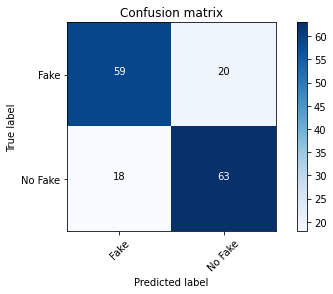

In [121]:
plot_confusion_matrix(confusion_matrix(y_val, y_pred), classes=["Fake","No Fake"])

Etant donnée la simplicité de nos features seulement 2 il n'est pas nécesaire ici d'appliquer des algorithmes de classifications plus performant sachant qu'ici une simple regression répond très bien à notre problème.

## Naives Bayes

<br>

Naives Bayes Approach Inference Rules for binary classification.
<br>

$$\prod_{i=1}^{n} \dfrac{P \left( wi \middle| \ Fake \right)}{P \left( wi \middle| \ NonFake \right)}$$
<br>
This expression says that we're going to take the product across all of the words (n words) in a post of the probability for each word in the fake class divide it by the probability in the non fake class
<br>

Laplacian Smoothing technique to avoid zero probability issue with the formula above
<br>

$$P \left( wi \middle| \ class \right) = \dfrac{freq(wi,class)+1}{Nc + Vc} \\ class \in \{ Fake , Non Fake \} $$
<br>

$N_c = \ $frequency of all words in class 
class
<br>

​$V =\ $number of unique words in vocabulary
<br>

In [186]:
X = df_train["text"]
y = df_train["truthRating"] 

# found when testing different parameters in the preprocessing  
text_normalizer= TextNormalizer(removestopwords=False,lowercase=True,getstemmer=False,removedigit=False) 
X=text_normalizer.fit_transform(X)

In [187]:
X_train,X_val,y_train,y_val = train_test_split(X,y,train_size=0.7,random_state=0)

nb = Pipeline([('vect', TfidfVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(X_val)

print('accuracy %s' % accuracy_score(y_pred, y_val))
print(classification_report(y_val, y_pred,target_names=["Fake", "No Fake"]))

accuracy 0.6483333333333333
              precision    recall  f1-score   support

        Fake       0.68      0.58      0.63       613
     No Fake       0.62      0.72      0.67       587

    accuracy                           0.65      1200
   macro avg       0.65      0.65      0.65      1200
weighted avg       0.65      0.65      0.65      1200



## Comparaison de tous les classifieurs

In [178]:
X = df_train["text"]
y = df_train["truthRating"]

### Cross Validation

In [179]:
# found when testing different parameters in the preprocessing  
text_normalizer= TextNormalizer(removestopwords=False,lowercase=True,getstemmer=False,removedigit=False) 
X=text_normalizer.fit_transform(X)

models = []
models.append(('LRregression', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('MultinomialNB', MultinomialNB()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('SGDClassifier',SGDClassifier()))
models.append(('RandomForest', RandomForestClassifier()))
models.append(('PassiveAggressiveClassifier',PassiveAggressiveClassifier()))

In [180]:
results = []
names = []
scoring = 'accuracy'
for name, model in models:
  kfold = KFold(n_splits=5, shuffle=False)
  model = make_pipeline(TfidfVectorizer(), model)
  cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

LRregression: 0.641250 (0.019089)
KNN: 0.595000 (0.011699)
MultinomialNB: 0.631250 (0.013578)
DecisionTreeClassifier: 0.572750 (0.008782)
SVM: 0.640250 (0.016982)
SGDClassifier: 0.613000 (0.006500)
RandomForest: 0.622500 (0.020600)
PassiveAggressiveClassifier: 0.600750 (0.012057)


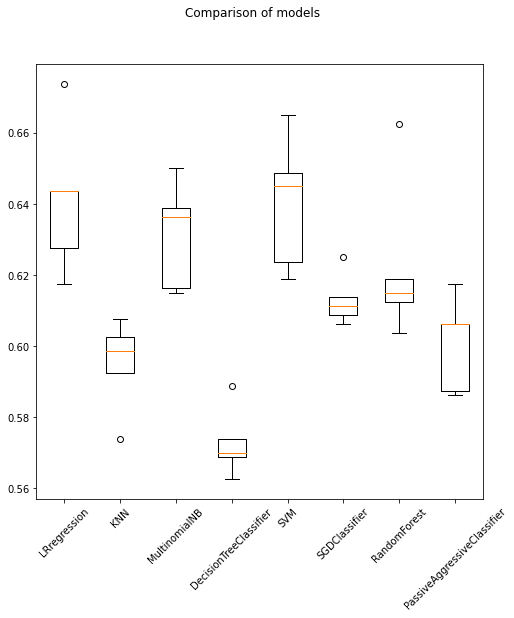

In [181]:
fig = plt.figure(figsize=(8,8))
fig.suptitle('Comparison of models')
ax = fig.add_subplot(111)
ax.boxplot(results)
ax.set_xticklabels(names,rotation = 45)
plt.show()

As we expected LogRegression and MultionomialNB are the classifiers that perform the best.

### Entrainement sur le Test Set avec affinement des paramètres des meilleurs classifieurs

In [183]:
X_train,X_val,y_train,y_val = train_test_split(X,y,train_size=0.7,random_state=0)

pipe = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression()),
              ])
grid = {"clf__C":np.logspace(-3,4,7)}

gd_srLR = GridSearchCV(pipe,  
                     param_grid=grid,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1,
                    return_train_score=True)

gd_srLR.fit(X_train, y_train)
print ('meilleur score ',
 gd_srLR.best_score_,'\n')
print ('meilleurs paramètres',
 gd_srLR.best_params_,'\n')
print ('meilleur estimateur',
gd_srLR.best_estimator_,'\n')

meilleur score  0.6249999999999999 

meilleurs paramètres {'clf__C': 3.1622776601683795} 

meilleur estimateur Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=3.1622776601683795))]) 



In [184]:
# Creation d'une instance de l'algorithme en utilisant les meilleurs paramètres
lr = gd_srLR.best_estimator_

lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
print('\n accuracy: ', accuracy_score(y_pred, y_val),'\n')

print('\n',classification_report(y_val, y_pred))
confusion_matrix(y_val, y_pred)


 accuracy:  0.6533333333333333 


               precision    recall  f1-score   support

           0       0.67      0.64      0.66       613
           1       0.64      0.66      0.65       587

    accuracy                           0.65      1200
   macro avg       0.65      0.65      0.65      1200
weighted avg       0.65      0.65      0.65      1200



array([[395, 218],
       [198, 389]])

### Evaluation sur le test Set